In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv("/content/gdrive/MyDrive/ml-100k/ua.base", sep="\t", 
            names=["user", "item", "ratings", "timestamp"])
test = pd.read_csv("/content/gdrive/MyDrive/ml-100k/ua.test", sep="\t", 
            names=["user", "item", "ratings", "timestamp"])


,user,item,ratings,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
90565,943,1047,2,875502146
90566,943,1074,4,888640250
90567,943,1188,3,888640250
90568,943,1228,3,888640275


In [6]:
users = torch.LongTensor(train["user"])
items = torch.LongTensor(train["item"])
ratings = torch.FloatTensor(train["ratings"])

users_test = torch.LongTensor(test["user"])
items_test = torch.LongTensor(test["item"])
ratings_test = torch.LongTensor(test["ratings"])

In [21]:
rank = 10
num_users = users.max() + 1
num_items = items.max() + 1

P = torch.randn(num_users, rank, requires_grad=True)
Q = torch.randn(num_items, rank, requires_grad=True)

optimizer = torch.optim.Adam([P,Q], lr=0.1)


X = []
Y = []
Y_test = []

for epoch in range(1001):
  hypo = (P[users] * Q[items]).sum(dim=1)
  cost = F.mse_loss(hypo, ratings)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  with torch.no_grad():
    X.append(epoch)
    Y.append(cost.item())

    hypo_test = (P[users_test] * Q[items_test]).sum(dim=1)
    cost_test = F.mse_loss(hypo_test, ratings_test)
    Y_test.append(cost_test.item())

    if epoch % 100 == 0:
      print(f"epoch: {epoch}, cost:{cost.item()}, cost_test:{cost_test.item()}")



epoch: 0, cost:23.874103546142578, cost_test:22.139266967773438
epoch: 100, cost:0.5633122324943542, cost_test:1.5623003244400024
epoch: 200, cost:0.4924214780330658, cost_test:1.912723422050476
epoch: 300, cost:0.4711175858974457, cost_test:2.2544360160827637
epoch: 400, cost:0.4607672691345215, cost_test:2.6470189094543457
epoch: 500, cost:0.4548172652721405, cost_test:3.095144748687744
epoch: 600, cost:0.4510841369628906, cost_test:3.506682872772217
epoch: 700, cost:0.4485485553741455, cost_test:3.889117956161499
epoch: 800, cost:0.4466700851917267, cost_test:4.282528400421143
epoch: 900, cost:0.4451338052749634, cost_test:4.721318244934082
epoch: 1000, cost:0.443820983171463, cost_test:5.246633052825928


In [22]:
rank = 10
num_users = users.max() + 1
num_items = items.max() + 1

P = torch.randn(num_users, rank, requires_grad=True)
Q = torch.randn(num_items, rank, requires_grad=True)

optimizer = torch.optim.Adam([P,Q], lr=0.1)

lambda_P = 0.0001
lambda_Q = 0.0001

X = []
Y = []
Y_test = []

for epoch in range(1001):
  hypo = (P[users] * Q[items]).sum(dim=1)
  mse = F.mse_loss(hypo, ratings)
  cost = mse + lambda_P * (P**2).sum() + lambda_Q * (Q**2).sum()

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  with torch.no_grad():
    X.append(epoch)
    Y.append(mse.item())

    hypo_test = (P[users_test] * Q[items_test]).sum(dim=1)
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test.append(mse_test.item())

    if epoch % 100 == 0:
      print(f"epoch: {epoch}, mse:{mse.item()}, mse_test:{mse_test.item()}")



epoch: 0, mse:23.484914779663086, mse_test:21.09608268737793
epoch: 100, mse:0.6889662742614746, mse_test:1.059688925743103
epoch: 200, mse:0.643653154373169, mse_test:1.061043381690979
epoch: 300, mse:0.6310486793518066, mse_test:1.0573389530181885
epoch: 400, mse:0.6275273561477661, mse_test:1.0553057193756104
epoch: 500, mse:0.6266985535621643, mse_test:1.0537805557250977
epoch: 600, mse:0.6264886856079102, mse_test:1.0531445741653442
epoch: 700, mse:0.6263757944107056, mse_test:1.052925705909729
epoch: 800, mse:0.6262785792350769, mse_test:1.052931785583496
epoch: 900, mse:0.6261938214302063, mse_test:1.0531216859817505
epoch: 1000, mse:0.62612384557724, mse_test:1.0534547567367554


In [23]:
rank = 10
num_users = users.max() + 1
num_items = items.max() + 1

P = torch.randn(num_users, rank, requires_grad=True)
Q = torch.randn(num_items, rank, requires_grad=True)


bias_user = torch.randn(num_users, requires_grad=True)
bias_item = torch.randn(num_items, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

optimizer = torch.optim.Adam([P,Q, bias_user, bias_item], lr=0.1)

lambda_P = 0.0001
lambda_Q = 0.0001
lambda_BU = 0.0001
lambda_BI = 0.0001

X = []
Y = []
Y_test = []

for epoch in range(1001):
  hypo = (P[users] * Q[items]).sum(dim=1) + bias_user[users] + bias_item[items] + mean
  mse = F.mse_loss(hypo, ratings)
  cost = mse + lambda_P * (P**2).sum() + lambda_Q * (Q**2).sum() + \
          lambda_BU * (bias_user**2).sum() + lambda_BI * (bias_item**2).sum()

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  with torch.no_grad():
    X.append(epoch)
    Y.append(mse.item())

    hypo_test = (P[users_test] * Q[items_test]).sum(dim=1) + \
                bias_user[users_test] + bias_item[items_test] + mean
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test.append(mse_test.item())

    if epoch % 100 == 0:
      print(f"epoch: {epoch}, mse:{mse.item()}, mse_test:{mse_test.item()}")



epoch: 0, mse:13.379758834838867, mse_test:10.499831199645996
epoch: 100, mse:0.6061757206916809, mse_test:0.8778351545333862
epoch: 200, mse:0.5796006917953491, mse_test:0.8702333569526672
epoch: 300, mse:0.5755806565284729, mse_test:0.870954692363739
epoch: 400, mse:0.573808491230011, mse_test:0.8734675049781799
epoch: 500, mse:0.5731914639472961, mse_test:0.8739627599716187
epoch: 600, mse:0.5729454159736633, mse_test:0.8733160495758057
epoch: 700, mse:0.5728240609169006, mse_test:0.8726574778556824
epoch: 800, mse:0.5727621912956238, mse_test:0.8721418976783752
epoch: 900, mse:0.5727220773696899, mse_test:0.87167888879776
epoch: 1000, mse:0.5726909637451172, mse_test:0.8712325096130371


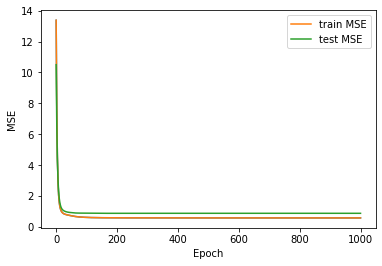

In [24]:
plt.plot(X, Y)
plt.xlabel("Epoch")
plt.ylabel("MSE")

plt.plot(X, Y, label="train MSE")
plt.plot(X, Y_test, label="test MSE")
plt.legend()

plt.show()